## Gaussian Mixture Model (GMM) for Well Log Analysis
GR (Gamma Ray)

# 1. Introduction

This notebook applies the Gaussian Mixture Model (GMM) for clustering and anomaly detection on well log data.  
We analyze three key geophysical well logs:
- **GR (Gamma Ray)**
- **NPHI (Neutron Porosity)**
- **DT (Sonic Travel Time)**
- **RHOB (Density)**  
from wells F17-04 and F15-A-01.  
The objective is to:
1. Cluster the data using GMM.
2. Detect anomalies based on GMM probability thresholds.
3. Visualize results using contour plots.



# 2. Libraries and Data Loading


The necessary libraries for GMM clustering, visualization, and evaluation are imported.  
The dataset consists of well log measurements for two features: NPHI of Well F17-04 and Well F15-A-01.  


In [17]:
import numpy as np
import pandas as pd
# import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import multivariate_normal

In [18]:
# Set random seem for reproducibility
manualSeed = 2019
np.random.seed(manualSeed)

In [19]:
data = pd.read_csv('/home/g202103050/Documents/A.Rahman/GAN anomally detection/Gans-for-anomaly-detection-master/datasets/GMM/train.GR.csv', header=None)
data = data.values

# 3. GMM Clustering

Gaussian Mixture Model (GMM) is used to cluster the well log data into two clusters (n_components=2).  
Ellipses are drawn around clusters to represent the 1, 2, and 3-sigma confidence intervals.


In [20]:

# Define functions
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance."""
    ax = ax or plt.gca()
    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):  # Draw 1, 2, and 3 sigma ellipses
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                              angle=angle, **kwargs))  # Correctly passing angle

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
        

### - Algos

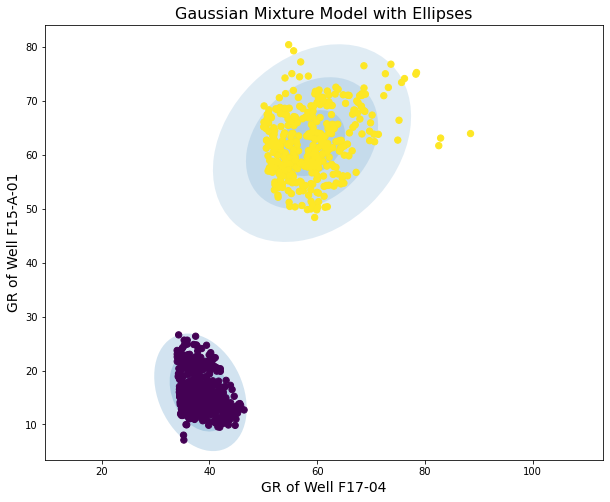

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture as GMM
import os

# Define output directory
output_dir = "plots"  # Change this path if needed
os.makedirs(output_dir, exist_ok=True)

# Apply Gaussian Mixture Model
cluster_num = 2
gmm_model = GMM(n_components=cluster_num, random_state=manualSeed).fit(data)

# Plot the results
plt.figure(figsize=(10, 8))
plot_gmm(gmm_model, data)
plt.title("Gaussian Mixture Model with Ellipses", fontsize=16)
plt.xlabel("GR of Well F17-04", fontsize=14)
plt.ylabel("GR of Well F15-A-01", fontsize=14)

# Save the plot in high resolution
output_file = os.path.join(output_dir, "GMM_with_Ellipses.png")
plt.savefig(output_file, dpi=600, bbox_inches='tight')

# Show the plot
plt.show()


### - Multi-variables

In [22]:
x = np.arange(round(min(data[:, 0])) - 10, round(max(data[:, 0])) + 10, 0.1)
y = np.arange(round(min(data[:, 1])) - 10, round(max(data[:, 1])) + 10, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)

a = xx + yy - yy
b = xx + yy - xx
mem = np.concatenate([
    a.reshape([a.shape[0], a.shape[1], 1]),
    b.reshape([a.shape[0], a.shape[1], 1])
],
                     axis=2)

In [23]:
pred = np.zeros([mem.shape[0], mem.shape[1]])
scaler = np.zeros(cluster_num)
for i in range(mem.shape[0]):
    for j in range(mem.shape[1]):
        for idx in range(cluster_num):
            scaler[idx] = np.maximum(
                scaler[idx],
                multivariate_normal.pdf(mem[i, j, :].reshape([1, -1]),
                                        mean=gmm_model.means_[idx, :],
                                        cov=gmm_model.covariances_[idx, :] *
                                        10))

In [24]:
for i in range(mem.shape[0]):
    for j in range(mem.shape[1]):
        for idx in range(cluster_num):
            pred[i, j] = np.maximum(
                pred[i, j],
                multivariate_normal.pdf(
                    mem[i, j, :].reshape([1, -1]),
                    mean=gmm_model.means_[idx, :],
                    cov=gmm_model.covariances_[idx, :] * 10) / scaler[idx])

# 4. Contour Visualization

The GMM model's probability density functions are visualized as contour plots.  
Test data points are overlaid to show whether they lie above or below the defined probability threshold.


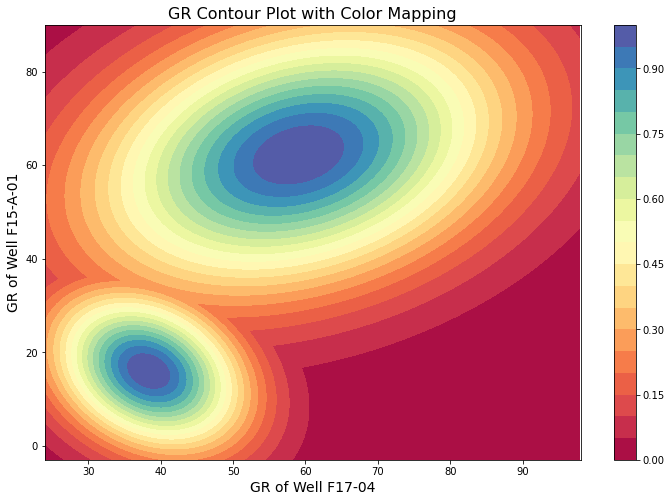

In [25]:
import matplotlib.pyplot as plt
import os
# Define the output directory
output_dir = '/home/g202103050/Documents/A.Rahman/GAN anomally detection/Gans-for-anomaly-detection-master/datasets/GMM/Results nad saved models/plots'  # Change this to your desired path
# Create the figure
plt.figure(figsize=(12, 8))

# Create contour plot
h = plt.contourf(x, y, pred / np.max(pred), 20, cmap='Spectral')
#plt.plot(data[:, 0], data[:, 1], '.b', label='Real')
plt.colorbar()

# Set limits
plt.xlim(round(min(data[:, 0])) - 10, round(max(data[:, 0])) + 10)
plt.ylim(round(min(data[:, 1])) - 10, round(max(data[:, 1])) + 10)


# Set title and labels
plt.title("GR Contour Plot with Color Mapping", fontsize=16)
plt.xlabel("GR of Well F17-04", fontsize=14)
plt.ylabel("GR of Well F15-A-01", fontsize=14)

# Save the plot
plt.savefig(os.path.join(output_dir, "GR_Contour_Plot_with_Color Mapping.png"), dpi=900, bbox_inches="tight")

# Show the plot
plt.show()

# 5. GMM Model Evaluation

## Model Evaluation
The GMM model is evaluated using test data with the following metrics:
- Precision: Proportion of correctly identified anomalies.
- Recall: Proportion of actual anomalies detected.
- F1 Score: Harmonic mean of Precision and Recall.


In [26]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [27]:
test = pd.read_csv('/home/g202103050/Documents/A.Rahman/GAN anomally detection/Gans-for-anomaly-detection-master/datasets/GMM/test.GR.csv', header=None)
test = test.values
label = test[:, 2]
label = label.reshape([-1, 1])
test = test[:, :2]

In [28]:
test_score = np.zeros([len(test)])
for iter in range(len(test)):
    for idx in range(cluster_num):
        test_score[iter] = np.maximum(
            test_score[iter],
            multivariate_normal.pdf(test[iter, :],
                                    mean=gmm_model.means_[idx, :],
                                    cov=gmm_model.covariances_[idx, :] * 10) /
            scaler[idx])

In [30]:
alpha = 0.75 #* np.max(test_score)
for i in range(test_score.shape[0]):
    if test_score[i] > alpha:
        test_score[i] = 0
    else:
        test_score[i] = 1

precision = average_precision_score(label, test_score)
recall = recall_score(label, test_score)
F1 = 2 * (precision * recall) / (precision + recall)
print('Precision score: {0:0.2f}'.format(precision))
print('Recall score: {0:0.2f}'.format(recall))
print('F1 score: {0:0.2f}'.format(F1))

Precision score: 0.38
Recall score: 0.95
F1 score: 0.54


## Visualizations
1. GMM clustering in 3D (GR, NPHI, DT, RHOB).
2. Test point classifications overlaid on contour plots.


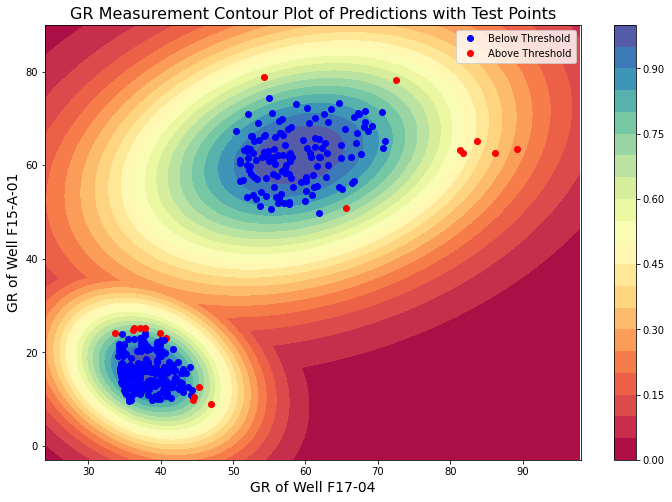

In [31]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Define the output directory
output_dir = '/home/g202103050/Documents/A.Rahman/GAN anomally detection/Gans-for-anomaly-detection-master/datasets/GMM/Results nad saved models/plots'  # Change this to your desired path

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Create the figure
plt.figure(figsize=(12, 8))

# Create contour plot
h = plt.contourf(x, y, pred / np.max(pred), 20, cmap='Spectral')
plt.colorbar()

# Set limits
plt.xlim(round(min(data[:, 0])) - 10, round(max(data[:, 0])) + 10)
plt.ylim(round(min(data[:, 1])) - 10, round(max(data[:, 1])) + 10)

# Initialize flags for legend labels
above_threshold_label_added = False
below_threshold_label_added = False

# Plot test data points with conditions
for i in range(test_score.shape[0]):
    if test_score[i] > alpha:
        if not above_threshold_label_added:
            plt.plot(test[i, 0], test[i, 1], 'ob', label='Below Threshold')
            above_threshold_label_added = True
        else:
            plt.plot(test[i, 0], test[i, 1], 'ob')
    else:
        if not below_threshold_label_added:
            plt.plot(test[i, 0], test[i, 1], 'or', label='Above Threshold')
            below_threshold_label_added = True
        else:
            plt.plot(test[i, 0], test[i, 1], 'or')

# Set title and labels
plt.title("GR Measurement Contour Plot of Predictions with Test Points", fontsize=16)
plt.xlabel("GR of Well F17-04", fontsize=14)
plt.ylabel("GR of Well F15-A-01", fontsize=14)

# Add legend
plt.legend(loc='upper right')

# Save the plot
plt.savefig(os.path.join(output_dir, "GR_Contour_Plot_of_Predictions_with_Color_Mapping.png"), dpi=600, bbox_inches="tight")

# Show the plot
plt.show()
